<a href="https://colab.research.google.com/github/Navaneeth-84/sentiment-analysis/blob/main/Twiiter_Culmulative_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis on Twitter data using Python

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive



**We use the GPU for this notebook to speed things up:** select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE".



We will need Twitter API keys  to make this work. We can get those by signing up here: https://developer.twitter.com/en/apps

Import a bunch of libraries and install Flair.

In [ ]:
# import lot of libraries that we will be using along the process

!pip install emoji
!pip install regex
!pip install emosent-py
!pip install flair

import warnings
import sys
import os
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob

import regex
import emoji
from emosent import get_emoji_sentiment_rank

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import clear_output
from tqdm import tqdm
import csv

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

### Authenticate with Twitter API

Read Credentails from the file **keys.csv**

In [ ]:
with open('/content/drive/MyDrive/keys.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        API_K = row[0]
        API_S = row[1]
        ACC_K = row[2]
        ACC_S = row[3]

Authenticate

In [ ]:
# Authenticate
auth = tweepy.AppAuthHandler(API_K, API_S)

api = tweepy.API(auth, wait_on_rate_limit=True,
				   wait_on_rate_limit_notify=True)

if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

### Importing and Training our model

Importing a pre-trained model

In [ ]:
# import Flair model

from flair.data import Sentence
from flair.models import SequenceTagger
from flair.models import TextClassifier

from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
tagger = SequenceTagger.load('ner')

Training the imported model over desirable epoches

In [ ]:
# import flair datasets

from flair.datasets import TREC_6

# load the corpus
corpus = TREC_6()

# create a label dictionary
label_Dictionary = corpus.make_label_dictionary() 

# list of word embeddings to be used
word_embeddings = [WordEmbeddings('glove'),FlairEmbeddings('news-forward-fast')]

# init document embeddings and pass the word embeddings list
doc_embeddings = DocumentRNNEmbeddings(word_embeddings,hidden_size = 250)

# creating the text classifier
classifier = TextClassifier(doc_embeddings,label_dictionary = label_Dictionary)

# init the text classifier trainer
model_trainer = ModelTrainer(classifier,corpus)

# train your model
model_trainer.train('resources/taggers/trec',learning_rate=0.1,
                    mini_batch_size=40,anneal_factor=0.5,patience=5,max_epochs=10)

Test the model's accuracy with a simple sentence

In [ ]:
# load the final model
classifier_text = TextClassifier.load('en-sentiment')
classifier_tags = TextClassifier.load('resources/taggers/trec/final-model.pt')

2021-08-21 07:25:48,855 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt
2021-08-21 07:25:56,215 loading file resources/taggers/trec/final-model.pt


In [ ]:
s = Sentence('The university of California is owned by Mr. peter.')
  
# run NER over a sentence
tagger.predict(s)

print('The following NER tags are found:\n')
  
# iterate and print
for entity in s.get_spans('ner'):
    print(entity)

## Scraping through the twitter cursor

We need to provide a Search term and a Max Tweet count. Twitter lets you to request 45,000 tweets every 15 minutes  so setting something below that works.

In [ ]:
#@title Twitter Search API Inputs
#@markdown ### Enter Search Query:
searchQuery = '#AfganLivesMatter' #@param {type:"string"}
#@markdown ### Enter Max Tweets To Scrape:
#@markdown #### The Twitter API Rate Limit (currently) is 45,000 tweets every 15 minutes.
maxTweets = 500 #@param {type:"slider", min:0, max:45000, step:100}
Filter_Retweets = False #@param {type:"boolean"}
#@markdown Enter a date from which tweets shall be drawn in
dateSince = '2021-08-15' #@param {type:"date"}
tweetsPerQry = 100  # this is the max the API permits
tweet_lst = []

if Filter_Retweets:
  searchQuery = searchQuery + ' -filter:retweets'  # to exclude retweets

tweetCount = 0

print("Downloading max {0} tweets".format(maxTweets))
while tweetCount < maxTweets:
  try:
    new_tweets = api.search(q=searchQuery, count=tweetsPerQry,lang="en", since=dateSince)
    if not new_tweets:
        print("No more tweets found")
        break
    for tweet in new_tweets:
      if hasattr(tweet, 'reply_count'):
        reply_count = tweet.reply_count
      else:
        reply_count = 0
      if hasattr(tweet, 'retweeted'):
        retweeted = tweet.retweeted
      else:
        retweeted = "NA"
            
      # fixup search query to get topic
      topic = searchQuery[:searchQuery.find('-')].capitalize().strip()
          
      # fixup date
      tweetDate = tweet.created_at.date()
          
      tweet_lst.append([tweetDate, topic, 
                      tweet.id, tweet.user.screen_name, tweet.user.name, tweet.text, tweet.favorite_count, 
                      reply_count, tweet.retweet_count, retweeted])

    tweetCount += len(new_tweets)
    print("Downloaded {0} tweets".format(tweetCount))
    max_id = new_tweets[-1].id
  except tweepy.TweepError as e:

    # Just exit if any error
    print("some error : " + str(e))
    break

clear_output()
print("Downloaded {0} tweets".format(tweetCount))

Downloaded 500 tweets


##Data Sciencing

Let us feed the tweets we have drawn into dataframes for data preprocessing.
We also save the data into a file named **tweets.csv**.

In [ ]:
pd.set_option('display.max_colwidth', None)

# load it into a pandas dataframe

tweet_df = pd.DataFrame(tweet_lst, columns=['tweet_dt', 'topic', 'id',
                                            'username', 'name', 'tweet',
                                            'like_count', 'reply_count',
                                            'retweet_count', 'retweeted'])

# put into a csv file

tweet_df.to_csv('tweets.csv')

# glance at the contents

tweet_df.head(10)

Print **shape** of the dataframe to know number of tweets that the dataframe retains

In [ ]:
tweet_df.shape

(500, 10)

### NER and Sentiment Analysis


###NER

We extract and then append the Tags as separate rows in our dataframe. This helps us later to group by Tags. We also create a new ‘Hashtag’ tag as Flair does not recognize it and it’s a big one in this context.

### Sentiment Analysis

We use the Flair Classifier to get Polarity and Result and add those fields to our dataframe.

**Warning:** This can be slow if we have lots of tweets.

In [ ]:
# list of all ners detected
nerlst = []

for index, row in tqdm(tweet_df.iterrows(), total=tweet_df.shape[0]):

  cleanedTweet = row['tweet'].replace("#", "")

  sentence = Sentence(cleanedTweet, use_tokenizer=True)

  # predict NER tags
  classifier_tags.predict(sentence)

  # get ner
  ners = sentence.to_dict(tag_type='ner')['entities']
  
  # predict sentiment
  classifier_text.predict(sentence)

  for entity in sentence.get_spans('ner'):
      tag_type=entity.tag
  
  label = sentence.labels[0]
  response = {'result': label.value, 'polarity':label.score}

  # get hashtags
  hashtags = re.findall(r'#\w+', row['tweet'])
  if len(hashtags) >= 1:
    for hashtag in hashtags:
      ners.append({ 'type': 'Hashtag', 'text': hashtag })
      ners.append({ 'type':tag_type, 'text': hashtag })

  for ner in ners:
    adj_polarity = response['polarity']
    if response['result'] == 'NEGATIVE':
      adj_polarity = response['polarity'] * -1
    try:
      ner['type']
    except:
      ner['type'] = ''      
    nerlst.append([ row['tweet_dt'], row['topic'], row['id'], row['username'], 
                   row['name'], row['tweet'], ner['type'], ner['text'], response['result'], 
                   response['polarity'], adj_polarity, row['like_count'], row['reply_count'], 
                  row['retweet_count'] ])


100%|██████████| 500/500 [00:17<00:00, 28.62it/s]


In [ ]:
for x in range(int(len(nerlst)/3)):
  print (nerlst[x])

In [ ]:
df_ner = pd.DataFrame(nerlst, columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet', 'tag_type', 'tag', 'sentiment', 'polarity', 
                                       'adj_polarity','like_count', 'reply_count', 'retweet_count'])
df_ner.head(len(df_ner))

,tweet_dt,topic,id,username,name,tweet,tag_type,tag,sentiment,polarity,adj_polarity,like_count,reply_count,retweet_count
0,2021-08-21,#afganlivesmatte,1428970417331466241,MRHBV310199,H I T E S H ___BAWA,RT @Deepsi_ngh: Such positive gestures by American Army towards Afganistan's rescue \n#AmericanTaliban #AfganLivesMatter \n#AmericanArmy http…,Hashtag,#AmericanTaliban,POSITIVE,0.957195,0.957195,0,0,6
1,2021-08-21,#afganlivesmatte,1428970417331466241,MRHBV310199,H I T E S H ___BAWA,RT @Deepsi_ngh: Such positive gestures by American Army towards Afganistan's rescue \n#AmericanTaliban #AfganLivesMatter \n#AmericanArmy http…,LOC,#AmericanTaliban,POSITIVE,0.957195,0.957195,0,0,6
2,2021-08-21,#afganlivesmatte,1428970417331466241,MRHBV310199,H I T E S H ___BAWA,RT @Deepsi_ngh: Such positive gestures by American Army towards Afganistan's rescue \n#AmericanTaliban #AfganLivesMatter \n#AmericanArmy http…,Hashtag,#AfganLivesMatter,POSITIVE,0.957195,0.957195,0,0,6
3,2021-08-21,#afganlivesmatte,1428970417331466241,MRHBV310199,H I T E S H ___BAWA,RT @Deepsi_ngh: Such positive gestures by American Army towards Afganistan's rescue \n#AmericanTaliban #AfganLivesMatter \n#AmericanArmy http…,LOC,#AfganLivesMatter,POSITIVE,0.957195,0.957195,0,0,6
4,2021-08-21,#afganlivesmatte,1428970417331466241,MRHBV310199,H I T E S H ___BAWA,RT @Deepsi_ngh: Such positive gestures by American Army towards Afganistan's rescue \n#AmericanTaliban #AfganLivesMatter \n#AmericanArmy http…,Hashtag,#AmericanArmy,POSITIVE,0.957195,0.957195,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,2021-08-19,#afganlivesmatte,1428457252189458434,jithesh_s,Jithu,#SaveAfghanistan #AfganLivesMatter #AmrullahSaleh \nMove to #panjshir and join resistance. Taliban is no match for… https://t.co/FCMIoPk7ib,LOC,#AfganLivesMatter,NEGATIVE,0.999671,-0.999671,3,0,1
1246,2021-08-19,#afganlivesmatte,1428457252189458434,jithesh_s,Jithu,#SaveAfghanistan #AfganLivesMatter #AmrullahSaleh \nMove to #panjshir and join resistance. Taliban is no match for… https://t.co/FCMIoPk7ib,Hashtag,#AmrullahSaleh,NEGATIVE,0.999671,-0.999671,3,0,1
1247,2021-08-19,#afganlivesmatte,1428457252189458434,jithesh_s,Jithu,#SaveAfghanistan #AfganLivesMatter #AmrullahSaleh \nMove to #panjshir and join resistance. Taliban is no match for… https://t.co/FCMIoPk7ib,LOC,#AmrullahSaleh,NEGATIVE,0.999671,-0.999671,3,0,1
1248,2021-08-19,#afganlivesmatte,1428457252189458434,jithesh_s,Jithu,#SaveAfghanistan #AfganLivesMatter #AmrullahSaleh \nMove to #panjshir and join resistance. Taliban is no match for… https://t.co/FCMIoPk7ib,Hashtag,#panjshir,NEGATIVE,0.999671,-0.999671,3,0,1


Calculate Frequency, Likes, Replies, Retweets and Average Polarity per Tag.

In [ ]:
ner_groups = df_ner.groupby(['tag', 'tag_type']).agg({'tag': "count", 'adj_polarity': "mean",
                                                     'like_count': 'sum', 'reply_count': 'sum',
                                                     'retweet_count': 'sum'})
ner_groups = ner_groups.rename(columns={
    "tag": "Frequency",
    "adj_polarity": "Avg_Polarity",
    "like_count": "Total_Likes",
    "reply_count": "Total_Replies",
    "retweet_count": "Total_Retweets"
})
ner_groups = ner_groups.sort_values(['Frequency'], ascending=False)
ner_groups = ner_groups.reset_index()
ner_groups.head(len(ner_groups))

,tag,tag_type,Frequency,Avg_Polarity,Total_Likes,Total_Replies,Total_Retweets
0,#AfganLivesMatter,Hashtag,205,-0.353369,305,0,2275
1,#AfganLivesMatter,LOC,205,-0.353369,305,0,2275
2,#AmericanTaliban,Hashtag,35,0.955441,125,0,210
3,#AmericanTaliban,LOC,35,0.955441,125,0,210
4,#AfganistanWomen,LOC,30,-0.335137,35,0,1035
...,...,...,...,...,...,...,...
89,#AshrafGhaniRunsAway,Hashtag,5,-0.994849,0,0,635
90,#AmrullahSaleh,LOC,5,-0.999671,15,0,5
91,#AmrullahSaleh,Hashtag,5,-0.999671,15,0,5
92,#AfghanistanCrisis,LOC,5,-0.636571,15,0,0


In [ ]:
ner_groups['Sentiment'] = np.where(ner_groups['Avg_Polarity']>=0, 'POSITIVE', 'NEGATIVE')
ner_groups.head(len(ner_groups))

,tag,tag_type,Frequency,Avg_Polarity,Total_Likes,Total_Replies,Total_Retweets,Sentiment
0,#AfganLivesMatter,Hashtag,205,-0.353369,305,0,2275,NEGATIVE
1,#AfganLivesMatter,LOC,205,-0.353369,305,0,2275,NEGATIVE
2,#AmericanTaliban,Hashtag,35,0.955441,125,0,210,POSITIVE
3,#AmericanTaliban,LOC,35,0.955441,125,0,210,POSITIVE
4,#AfganistanWomen,LOC,30,-0.335137,35,0,1035,NEGATIVE
...,...,...,...,...,...,...,...,...
89,#AshrafGhaniRunsAway,Hashtag,5,-0.994849,0,0,635,NEGATIVE
90,#AmrullahSaleh,LOC,5,-0.999671,15,0,5,NEGATIVE
91,#AmrullahSaleh,Hashtag,5,-0.999671,15,0,5,NEGATIVE
92,#AfghanistanCrisis,LOC,5,-0.636571,15,0,0,NEGATIVE


### Emoji analysis

Our work with textual data is completed. Let us wrap up work that requires us to give out a sentiment of emojis now.

#### Calculating emoji sentiment

In [ ]:
em_list = []

passage = ''

for tweet in new_tweets:
    passage = passage + tweet.text

data = regex.findall(r'\X',passage)
for word in data:
    if len(emoji.demojize(word))>1:
       em_list.append(word)

# CONSTRUCTION

# print no of emojis found
if len(em_list) == 0:
    
    print("Oops!! 🥺 No emojis found .. 😒  Start over again 😉 ..")
    sys.exit(0)
else:
    
    print("Total no. of emojis found:", len(em_list))

    # find and count unique emojis, and form a separate list

    uniq_em_list = []
    for em in em_list:
        if em not in uniq_em_list:
            uniq_em_list.append(em)

    print("no. of unique emojis are:", len(uniq_em_list))
    
    # declare a dataframe to store information about emojis and their occurences and sentiments
    
    emoji_dict = {' emoji ':[],' name ':[],' number of occurences ':[],' sentiment ':[],' sentiment*occurences ':[]}
    
    emoji_frame = pd.DataFrame(emoji_dict)

    
    for item in uniq_em_list:
        
        try:

          sentiment = get_emoji_sentiment_rank(item).get('sentiment_score')

        except:

          continue
        
        sentiment_prod_occurences = sentiment*em_list.count(item)
        
        emoji_frame.loc[len(emoji_frame.index)] =  [item, emoji.demojize(item), em_list.count(item), sentiment, sentiment_prod_occurences]
        
    total_occurences = emoji_frame[' number of occurences '].sum()

    sum_single_sentiments = emoji_frame[' sentiment '].sum()

    sum_sentiments = emoji_frame[' sentiment*occurences '].sum()

    overall_single_sentiment = round(sum_single_sentiments/len(emoji_frame),2)
    
    overall_sentiment = round(sum_sentiments/total_occurences,2)


    print(' total number of unique analysable emojis :',len(emoji_frame),' Total occurences of analysable emojis: ',total_occurences)

    print('overall single emoji sentiment: ',overall_single_sentiment,' overall sentiment: ',overall_sentiment)


Total no. of emojis found: 2
no. of unique emojis are: 2
 total number of unique analysable emojis : 1  Total occurences of analysable emojis:  1.0
overall single emoji sentiment:  -0.12  overall sentiment:  -0.12


### Visualizing sentiment 

We generate some bar plots based on the following metrics:


*   Most Popular Tweets
*   Most Liked Tweets
*   Most Replied Tweets
*   Most Retweeted Tweets


We cut the plots by Sentiment i.e. the color of the bars tells us if the overall Sentiment was Positive or Negative.


Text(0.5, 0, '')

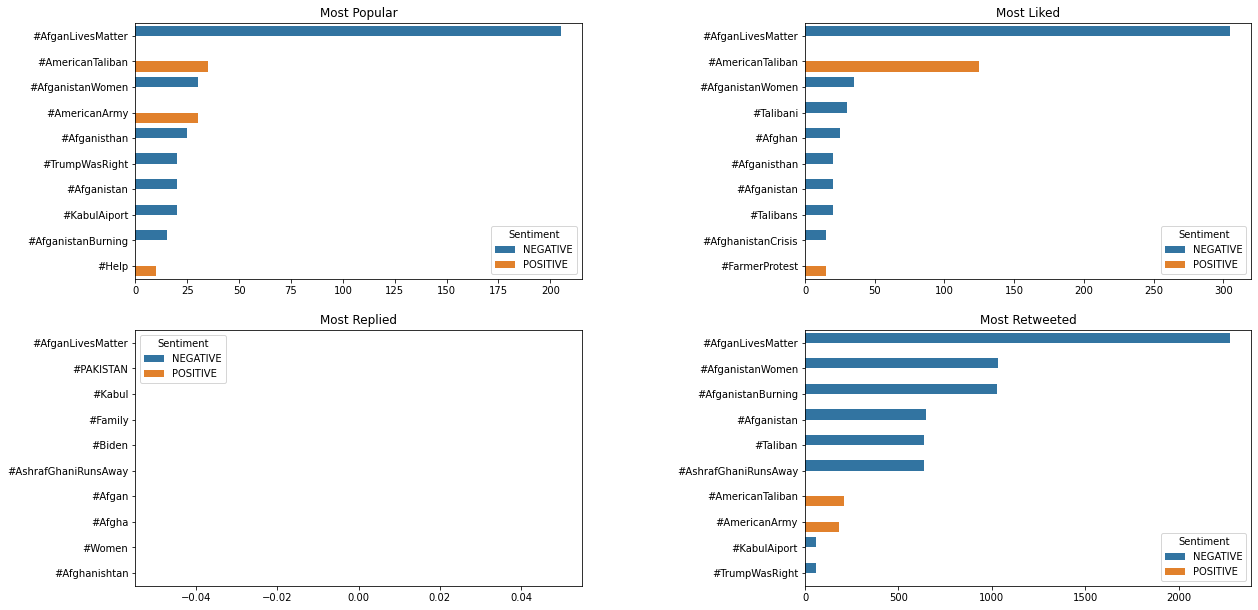

In [ ]:
#@title Visualize Top TAGs
Include_TAG = True #@param {type:"boolean"}
TAG = "Hashtag" #@param ["Hashtag", "Person", "Location", "Organisation", "Misc"]
#@markdown ###Pick how many tags to display per chart:
Top_N = 10 #@param {type:"integer"}

# get TAG value
if TAG != 'Hashtag':
  if TAG=='Person':
    TAG = TAG[:3].upper()
  elif TAG == 'Organisation':
    TAG='ORG'
  elif TAG == 'Misc':
    TAG = TAG[:4].upper()
  elif TAG == 'Location':
    TAG = TAG.upper

if Include_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups

# plot the figures
fig = plt.figure(figsize=(20, 16))
fig.subplots_adjust(hspace=0.2, wspace=0.5)

ax1 = fig.add_subplot(321)
sns.barplot(x="Frequency", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax2 = fig.add_subplot(322)
filtered_group = filtered_group.sort_values(['Total_Likes'], ascending=False)
sns.barplot(x="Total_Likes", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax3 = fig.add_subplot(323)
filtered_group = filtered_group.sort_values(['Total_Replies'], ascending=False)
sns.barplot(x="Total_Replies", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax4 = fig.add_subplot(324)
filtered_group = filtered_group.sort_values(['Total_Retweets'], ascending=False)
sns.barplot(x="Total_Retweets", y="tag", data=filtered_group[:Top_N], hue="Sentiment")

ax1.title.set_text('Most Popular')
ax2.title.set_text('Most Liked')
ax3.title.set_text('Most Replied')
ax4.title.set_text('Most Retweeted')

ax1.set_ylabel('')    
ax1.set_xlabel('')
ax2.set_ylabel('')    
ax2.set_xlabel('')
ax3.set_ylabel('')    
ax3.set_xlabel('')
ax4.set_ylabel('')    
ax4.set_xlabel('')

#### Visualizing emoji sentiment

In [ ]:
emoji_frame.head(len(emoji_frame))

,emoji,name,number of occurences,sentiment,sentiment*occurences
0,💔,:broken_heart:,1.0,-0.122,-0.122


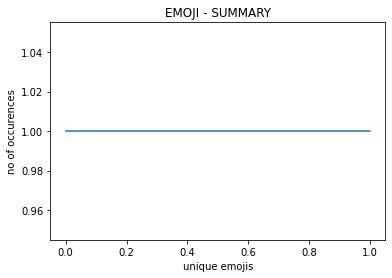

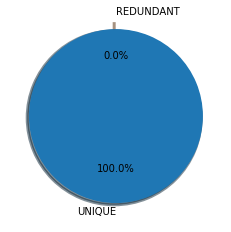

In [ ]:
import matplotlib.pyplot as plotter
y=[]
x=[]
c=0
for item in uniq_em_list:
    y.append(em_list.count(item))
    x.append(c)
    c=c+1
plotter.plot(x,y)
plotter.xlabel('unique emojis')
plotter.ylabel('no of occurences')
plotter.title('EMOJI - SUMMARY')
plotter.show()
    
#plotting a pie-chart for visualizing emoji redundancy

exp = [0,0.1]


ratio=len(uniq_em_list)/len(em_list)*100
plotter.pie([ratio,100-ratio],labels=['UNIQUE','REDUNDANT'],
            autopct='%1.1f%%',shadow=True, startangle=90,explode = exp,
            wedgeprops = {'linewidth': 3})
plotter.show()

####Get the Average Polarity Distribution.

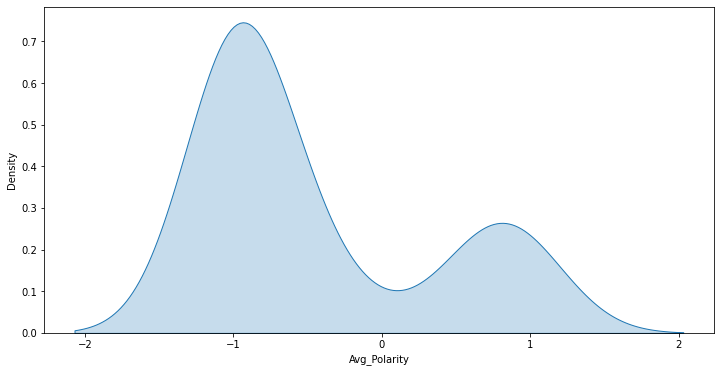

In [ ]:
fig = plt.figure(figsize=(12, 6))
sns.distplot(filtered_group['Avg_Polarity'], hist=False, kde_kws={"shade": True})
warnings.simplefilter(action='ignore', category=FutureWarning)

Create an overall Sentiment column based on the Average Polarity of the Tag.

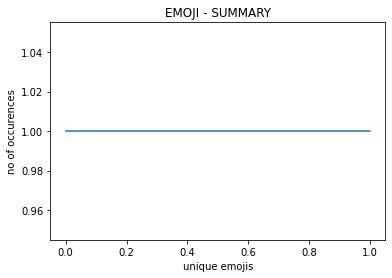

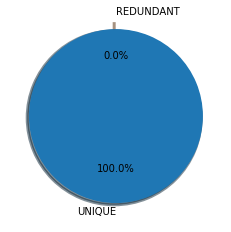

In [ ]:
import matplotlib.pyplot as plotter
y=[]
x=[]
c=0
for item in uniq_em_list:
    y.append(em_list.count(item))
    x.append(c)
    c=c+1
plotter.plot(x,y)
plotter.xlabel('unique emojis')
plotter.ylabel('no of occurences')
plotter.title('EMOJI - SUMMARY')
plotter.show()
    
#plotting a pie-chart for visualizing emoji redundancy

exp = [0,0.1]


ratio=len(uniq_em_list)/len(em_list)*100
plotter.pie([ratio,100-ratio],labels=['UNIQUE','REDUNDANT'],
            autopct='%1.1f%%',shadow=True, startangle=90,explode = exp,
            wedgeprops = {'linewidth': 3})
plotter.show()

## Word Cloud

Let's build a Word Cloud based on these metrics. 

Since I am interested in Seattle, I am going to use overlay the Seattle city skyline view over my Word Cloud. 
You can change this by selecting a different Mask option from the drop down.

In [ ]:
# download mask images to make a word cloud

!wget https://storage.needpix.com/rsynced_images/black-balloon.jpg -O balloon.jpg
  
#clear_output()

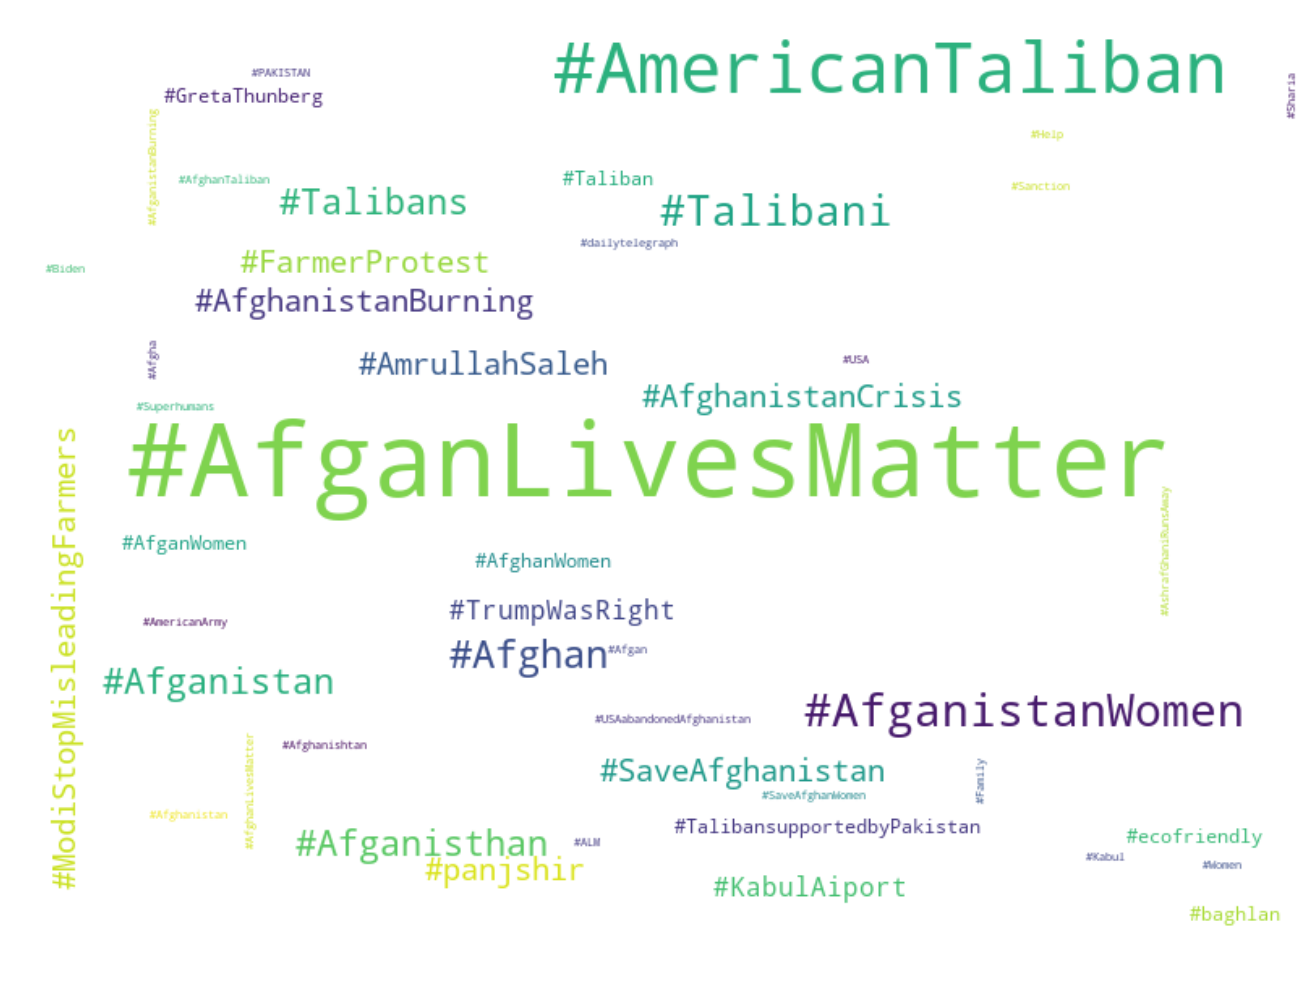

In [ ]:
#@title Build Word Cloud For Top TAGs
Metric = 'Most Liked' #@param ["Most Popular", "Most Liked", "Most Replied", "Most Retweeted"]
TAG = "Hashtag" 
Mask = "Rectangle" #@param ["Rectangle", "Balloon"]

# get correct Metric value
if Metric == 'Most Popular':
   Metric = 'Frequency'
elif Metric == 'Most Liked':
   Metric = 'Total_Likes'
elif Metric == 'Most Replied':
   Metric = 'Total_Replies'
elif Metric == 'Most Retweeted':
   Metric = 'Total_Retweets'    

# get TAG value

filtered_group = ner_groups

countDict = {}

for index, row in filtered_group.iterrows():
  if row[Metric] == 0:
    row[Metric] = 1
  countDict.update( {row['tag'] : row[Metric]} )
  

if Mask == 'Rectangle':
  Mask = np.array(Image.new('RGB', (800,600), (0, 0, 0)))

elif Mask == 'Balloon':
  Mask = np.array(Image.open("balloon.jpg"))

clear_output()

# Generate Word Cloud
wordcloud = WordCloud(
    max_words=100,
#     max_font_size=50,
    height=300,
    width=800,
    background_color = 'white',
    mask=Mask,
    contour_width=1,
    contour_color='steelblue',
    stopwords = STOPWORDS).generate_from_frequencies(countDict)
fig = plt.figure(
    figsize = (18, 18),
    )
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()